In [1]:
# импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS

# 0. Обработка данных

In [2]:
df = pd.read_csv('final_data_metrica_all.csv', encoding = 'cp1251', sep=";", na_values = ['-1.0'])
df = df[['floor','floors_count','rooms_count','total_meters', 'price', 'year_of_construction', 'kitchen_meters', 'underground']]
df.head()

,floor,floors_count,rooms_count,total_meters,price,year_of_construction,kitchen_meters,underground
0,13,14,2.0,68.3,13850000,2015.0,12.9,Кокошкино
1,1,5,2.0,43.1,13950000,1963.0,NaN,Щукинская
2,2,14,2.0,44.6,14700000,1971.0,5.8,Раменки
3,14,15,2.0,54.0,14700000,2019.0,12.1,Филатов Луг
4,11,19,2.0,67.3,23000000,2015.0,11.8,Пионерская


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710 entries, 0 to 709
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   floor                 710 non-null    int64  
 1   floors_count          710 non-null    int64  
 2   rooms_count           707 non-null    float64
 3   total_meters          710 non-null    float64
 4   price                 710 non-null    int64  
 5   year_of_construction  611 non-null    float64
 6   kitchen_meters        652 non-null    object 
 7   underground           694 non-null    object 
dtypes: float64(3), int64(3), object(2)
memory usage: 44.5+ KB


In [4]:
df = df[df['rooms_count'].notna()]
df = df[df['year_of_construction'].notna()]
df = df[df['kitchen_meters'].notna()]
df = df[df['underground'].notna()]

In [5]:
df['rooms_count'] = df['rooms_count'].astype('int64')
df['year_of_construction'] = df['year_of_construction'].astype('int64')
df['kitchen_meters'] = df['kitchen_meters'].astype('float64')

In [6]:
# Создадим список станций метро, которые относятся к центральному административному округу
CAO_underground = ['Рижская', 'Проспект Мира', 'Сухаревская',
                   'Тургеневская', 'Китай-город', 'Третьяковская',
                   'Октябрьская', 'Белорусская', 'Маяковская',
                   'Тверская', 'Театральная', 'Новокузнецкая',
                   'Павелецкая', 'Площадь Ильича', 'Марксистская',
                   'Третьяковская', 'Бауманская', 'Курская',
                   'Площадь Революции', 'Арбатская', 'Смоленская',
                   'Красносельская', 'Комсомольская', 'Красные Ворота',
                   'Чистые Пруды', 'Лубянка','Охотный Ряд', 'Библиотека им. Ленина',
                   'Парк Культуры', 'Фрунзенская', 'Спортивная',
                   'Воробьевы Горы', 'Кропоткинская', 'Смоленская',
                   'Арбатская', 'Александровский Сад', 'Проспект Мира',
                   'Комсомольская', 'Курская', 'Таганская', 'Павелецкая',
                   'Добрынинская', 'Октябрьская', 'Парк Культуры',
                   'Краснопресненская', 'Белорусская', 'Новослободская',
                   'Улица 1905 года', 'Баррикадная', 'Пушкинская',
                   'Кузнецкий Мост', 'Китай-город', 'Пролетарская',
                   'Таганская', 'Менделеевская', 'Цветной Бульвар',
                   'Чеховская', 'Боровицкая', 'Полянка', 'Серпуховская']

In [7]:
df['is_CAO'] = df['underground'].apply(lambda x: 1 if x in CAO_underground else 0)
df.drop('underground', axis = 1 , inplace= True)

In [8]:
def class_of_house(row):
    if 1820 <= row['year_of_construction'] < 1840:
        typ = 'Филановский'
    elif 1840 <= row['year_of_construction'] < 1855:
        typ = 'Никитинский'
    elif 1855 <= row['year_of_construction'] < 1870:
        typ = 'Ковалёвский'
    elif 1870 <= row['year_of_construction'] < 1940:
        typ = 'Печатники'
    elif 1940 <= row['year_of_construction'] < 1950:
        typ = 'Сталинка'
    elif 1950 <= row['year_of_construction'] < 1960:
        typ = 'Хрущёвка'
    elif 1960 <= row['year_of_construction'] < 1980:
        typ = 'Брежневка'
    elif 1980 <= row['year_of_construction'] < 2018:
        typ = 'Монолитный'
    else :
        typ = 'Новостройка'
    return typ

df['type'] = df.apply (class_of_house, axis=1)

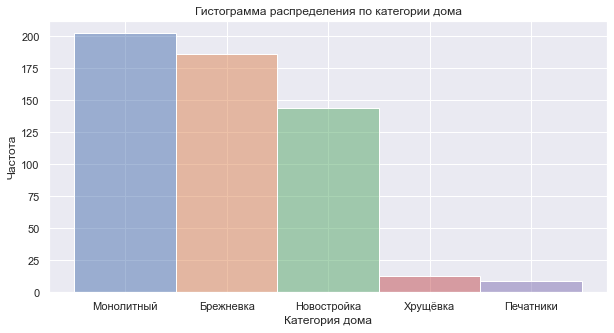

In [9]:
sns.set(rc = {'figure.figsize' : (10, 5)})
sns.histplot(x = 'type', hue = 'type', legend = False, data = df, bins = 50)
plt.xlabel('Категория дома')
plt.ylabel('Частота')
plt.title('Гистограмма распределения по категории дома');

In [10]:
df['house_category'] = df['type'].apply(lambda x: 1 if x == 'Монолитный' else 0)
df.drop('type', axis = 1 , inplace= True)

In [11]:
df.head()

,floor,floors_count,rooms_count,total_meters,price,year_of_construction,kitchen_meters,is_CAO,house_category
0,13,14,2,68.3,13850000,2015,12.9,0,1
2,2,14,2,44.6,14700000,1971,5.8,0,0
3,14,15,2,54.0,14700000,2019,12.1,0,0
4,11,19,2,67.3,23000000,2015,11.8,0,1
5,2,8,2,61.1,25950000,1958,10.0,0,0


# 1. Сводная статистическая информация

In [12]:
rows = len(df.axes[0]) 
cols = len(df.axes[1]) 

print("Количество наблюдений: " + str(rows)) 
print("Количество признаков: " + str(cols)) 

Количество наблюдений: 554
Количество признаков: 9


Кратко опишем имеющиеся в датасете признаки:
- floor - этаж, на котором находится квартира
- floors_count - общее количество этажей в доме
- rooms_count - количество комнат в квартире
- total_meters - общая площадь квартиры
- price - общая стоимость квартиры
- year_of_construction - год постройки дома
- kitchen_meters - площадь кухни
- is_CAO - бинарная переменная; расположена ли квартира в центре Москвы (где 1 - квартиры, расположенные на кольцевой линии метро и внутри неё, 0 - остальные)
- house_category - бинарная переменная; категория дома в зависимости от года постройки дома (где 1-монолитный дом, 0 - остальные).

In [13]:
describe_result = df.describe().round(2)
describe_result

,floor,floors_count,rooms_count,total_meters,price,year_of_construction,kitchen_meters,is_CAO,house_category
count,554.00,554.00,554.00,554.00,5.540000e+02,554.00,554.00,554.00,554.00
mean,7.84,15.28,1.49,45.33,1.580110e+07,1993.84,9.96,0.03,0.36
std,5.96,7.94,0.50,12.07,9.289277e+06,24.35,3.81,0.18,0.48
min,1.00,3.00,1.00,15.00,5.000000e+06,1895.00,3.00,0.00,0.00
25%,3.00,9.00,1.00,37.20,1.080000e+07,1971.00,7.50,0.00,0.00
50%,6.00,14.00,1.00,42.00,1.330000e+07,1997.50,9.45,0.00,0.00
75%,11.00,18.00,2.00,53.00,1.750000e+07,2018.00,11.00,0.00,1.00
max,35.00,85.00,2.00,125.00,1.000000e+08,2024.00,30.00,1.00,1.00


In [14]:
# Сохранение DataFrame в Excel
describe_result.to_excel('describe_results.xlsx', index = True)

## 2. Описательные статистики. Сбалансированность бинарных переменных

In [15]:
counts = df['is_CAO'].value_counts()
counts

0    536
1     18
Name: is_CAO, dtype: int64

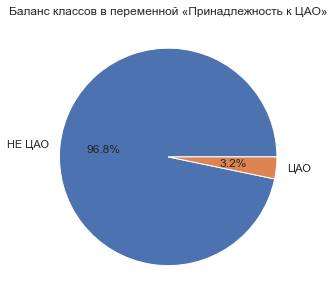

In [16]:
plt.pie(counts, labels = ['НЕ ЦАО', 'ЦАО'], autopct = '%1.1f%%')
plt.title('Баланс классов в переменной «Принадлежность к ЦАО»');

In [17]:
counts_ = df['house_category'].value_counts()
counts_

0    352
1    202
Name: house_category, dtype: int64

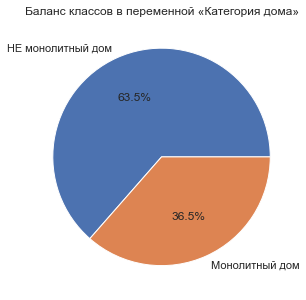

In [18]:
plt.pie(counts_, labels = ['НЕ монолитный дом', 'Монолитный дом'], autopct = '%1.1f%%')
plt.title('Баланс классов в переменной «Категория дома»');

## 3. Анализ гистограмм

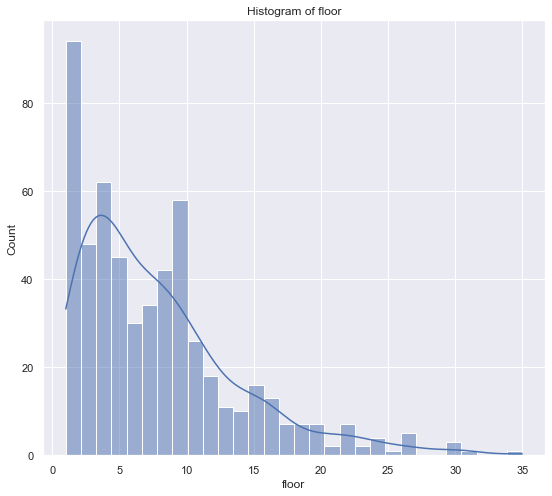

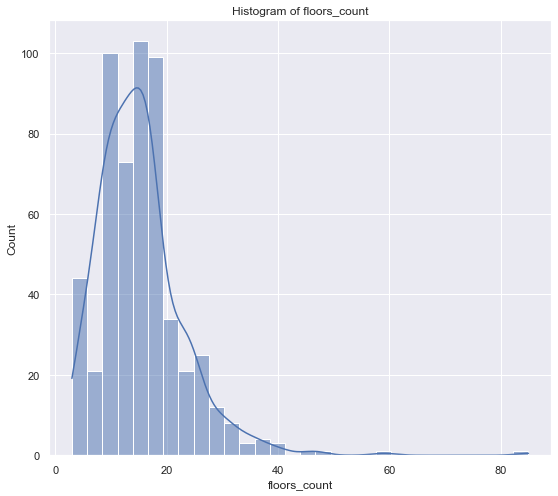

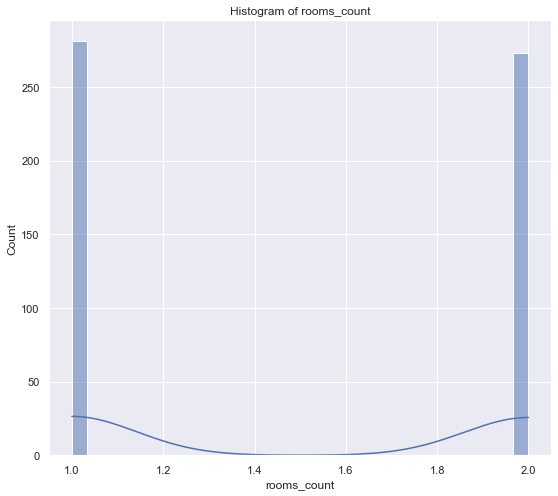

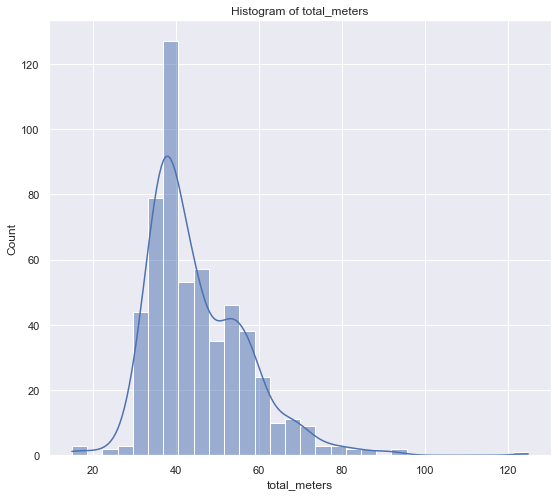

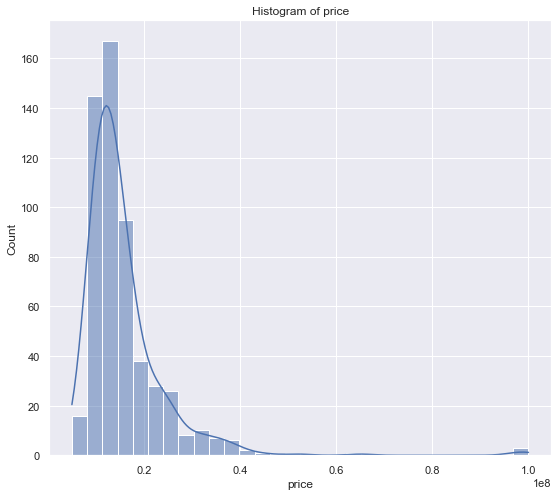

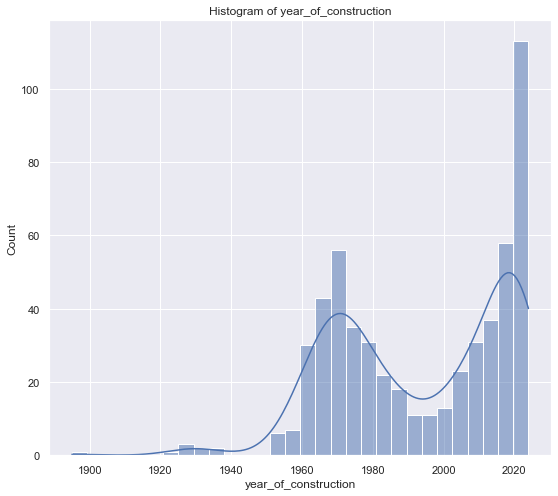

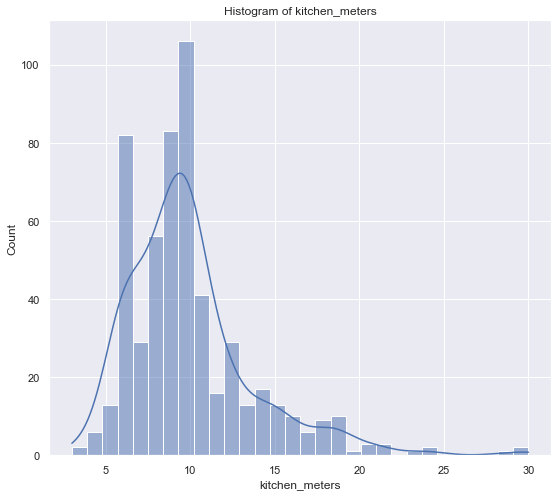

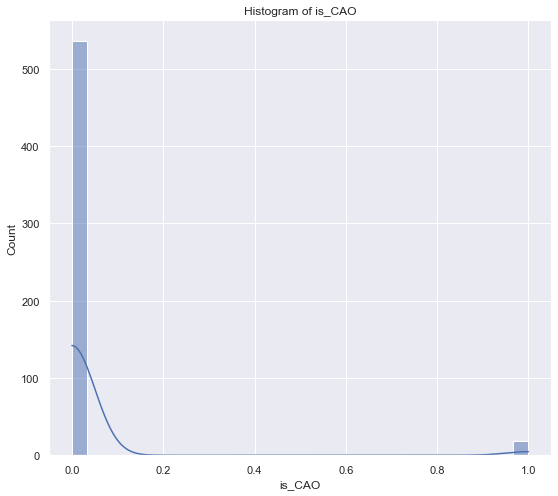

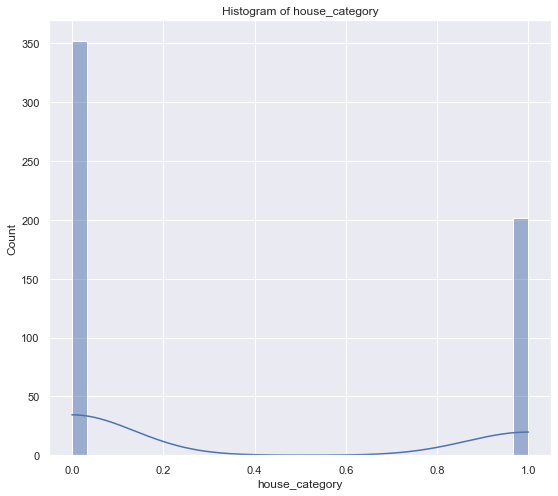

In [19]:
for column in df.columns:
  plt.figure(figsize = (9, 8))
  sns.histplot(df[column], kde = True, bins = 30)
  plt.title(f'Histogram of {column}')
  plt.show()

## 4. Анализ ящичковых диаграмм (boxplot)

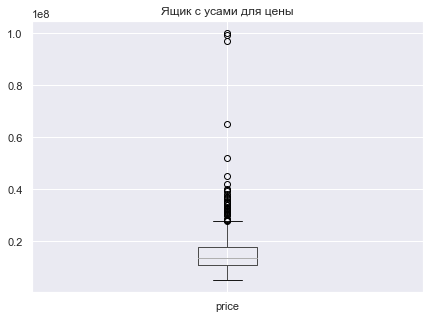

In [20]:
plt.figure(figsize = (7, 5))
df.boxplot(column = 'price')
plt.title('Ящик с усами для цены');

In [21]:
#найдем верхнюю границу ящика с усами и посчитаем количество выбросов
max_ = df['price'].describe()['75%'] + 1.5 * (df['price'].describe()['75%'] - df['price'].describe()['25%'])
df.loc[df['price'] > max_].shape[0]

38

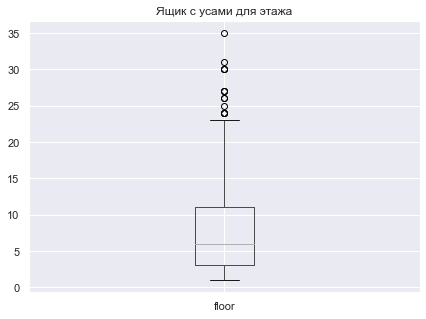

In [22]:
plt.figure(figsize = (7, 5))
df.boxplot(column = 'floor')
plt.title('Ящик с усами для этажа');

In [23]:
#найдем верхнюю границу ящика с усами и посчитаем количество выбросов
max_ = df['floor'].describe()['75%'] + 1.5 * (df['floor'].describe()['75%'] - df['floor'].describe()['25%'])
df.loc[df['floor'] > max_].shape[0]

15

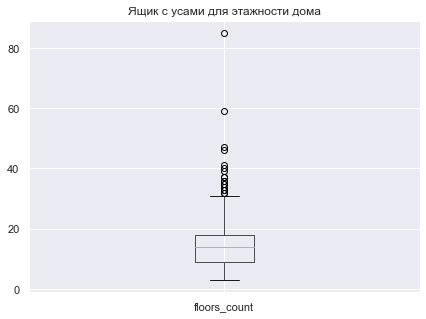

In [24]:
plt.figure(figsize = (7, 5))
df.boxplot(column = 'floors_count')
plt.title('Ящик с усами для этажности дома');

In [25]:
#найдем верхнюю границу ящика с усами и посчитаем количество выбросов
max_ = df['floors_count'].describe()['75%'] + 1.5 * (df['floors_count'].describe()['75%'] - df['floors_count'].describe()['25%'])
df.loc[df['floors_count'] > max_].shape[0]

19

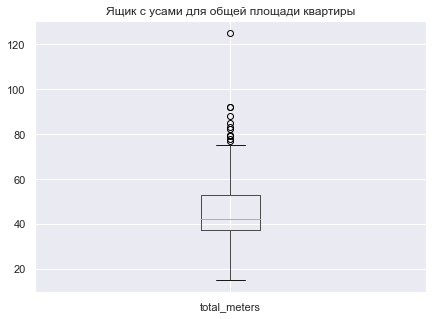

In [26]:
plt.figure(figsize = (7, 5))
df.boxplot(column = 'total_meters')
plt.title('Ящик с усами для общей площади квартиры');

In [27]:
#найдем верхнюю границу ящика с усами и посчитаем количество выбросов
max_ = df['total_meters'].describe()['75%'] + 1.5 * (df['total_meters'].describe()['75%'] - df['total_meters'].describe()['25%'])
df.loc[df['total_meters'] > max_].shape[0]

11

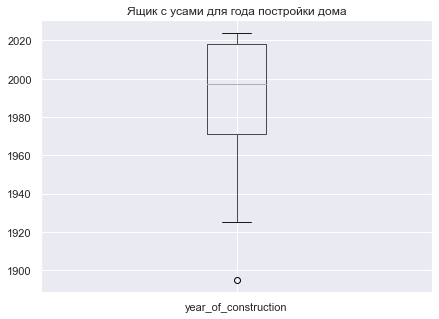

In [28]:
plt.figure(figsize = (7, 5))
df.boxplot(column = 'year_of_construction')
plt.title('Ящик с усами для года постройки дома');

In [29]:
#найдем нижнюю границу ящика с усами и посчитаем количество выбросов
max_ = df['year_of_construction'].describe()['25%'] - 1.5 * (df['year_of_construction'].describe()['75%'] - df['year_of_construction'].describe()['25%'])
df.loc[df['year_of_construction'] < max_].shape[0]

1

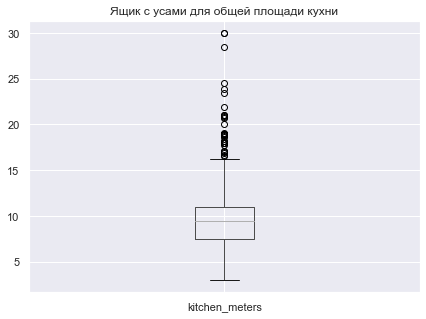

In [30]:
plt.figure(figsize = (7, 5))
df.boxplot(column = 'kitchen_meters')
plt.title('Ящик с усами для общей площади кухни');

In [31]:
#найдем верхнюю границу ящика с усами и посчитаем количество выбросов
max_ = df['kitchen_meters'].describe()['75%'] + 1.5 * (df['kitchen_meters'].describe()['75%'] - df['kitchen_meters'].describe()['25%'])
df.loc[df['kitchen_meters'] > max_].shape[0]

38

## 5. Матрица корреляции и тепловая карта

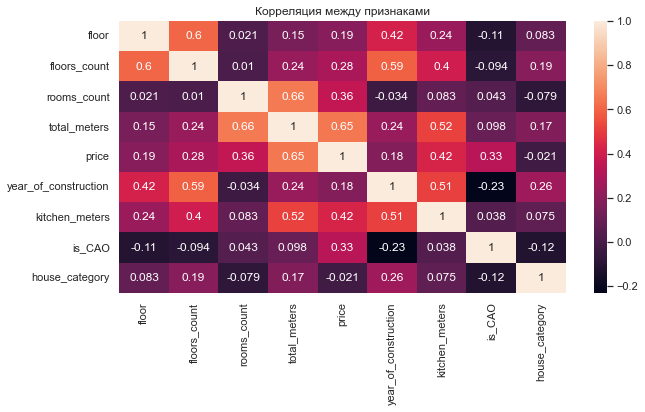

In [32]:
corr_matrix = df.corr()
plt.title('Корреляция между признаками')
sns.heatmap(corr_matrix, annot = True);

In [33]:
corr_matrix['price'].round(2)

floor                   0.19
floors_count            0.28
rooms_count             0.36
total_meters            0.65
price                   1.00
year_of_construction    0.18
kitchen_meters          0.42
is_CAO                  0.33
house_category         -0.02
Name: price, dtype: float64

Можно говорить о сильной статистической зависимости, если коэффициент корреляции r > 0,7. Среди наших переменных не наблюдается сильной корреляции с ценой, поэтому все параметры будут в дальнейшем включены в модель регрессии.

## 6. Анализ диаграмм рассеяния

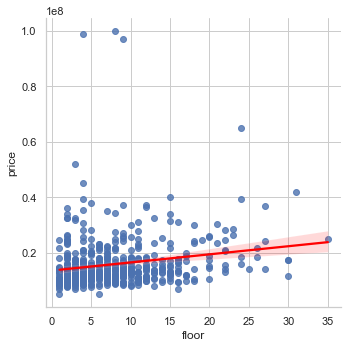

In [34]:
sns.set_style('whitegrid')
sns.lmplot(x ='floor', y ='price', data = df, line_kws={"color": "red"});

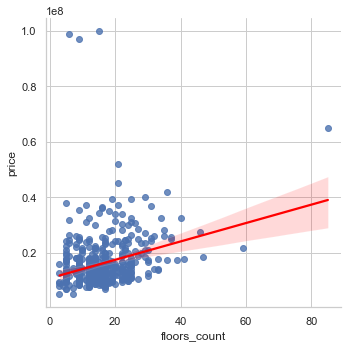

In [35]:
sns.set_style('whitegrid')
sns.lmplot(x ='floors_count', y ='price', data = df, line_kws={"color": "red"});

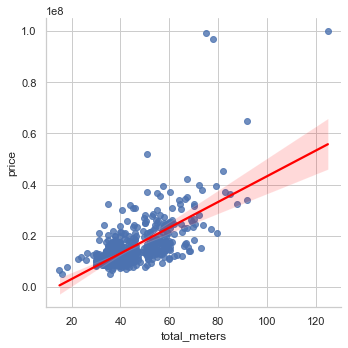

In [36]:
sns.set_style('whitegrid')
sns.lmplot(x ='total_meters', y ='price', data = df, line_kws={"color": "red"});

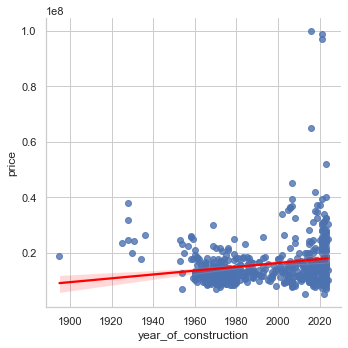

In [37]:
sns.set_style('whitegrid')
sns.lmplot(x ='year_of_construction', y ='price', data = df, line_kws={"color": "red"});

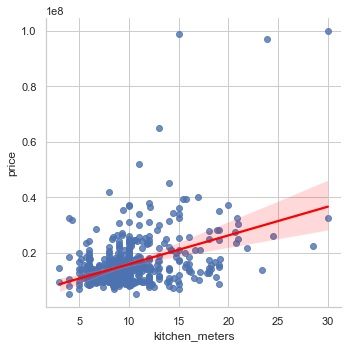

In [38]:
sns.set_style('whitegrid')
sns.lmplot(x ='kitchen_meters', y ='price', data = df, line_kws={"color": "red"});

## 7. Оценка первоначальной модели

In [39]:
def print_resids(preds, resids):
    ax = sns.regplot(preds, resids)
    ax.set(xlabel = 'Прогнозируемые значения', ylabel = 'Остатки', title = 'Прогнозируемые значения vs. Остатки')
    plt.show();

In [40]:
X = df[['floor', 'floors_count', 'rooms_count', 'total_meters', 'kitchen_meters', 'is_CAO', 'house_category' ]]
y = df['price']
lr = LinearRegression()
lr.fit(X, y)
result = smf.ols(formula = 'y ~ X', data = df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     94.17
Date:                Sun, 12 May 2024   Prob (F-statistic):           1.11e-89
Time:                        17:34:24   Log-Likelihood:                -9454.8
No. Observations:                 554   AIC:                         1.893e+04
Df Residuals:                     546   BIC:                         1.896e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7.554e+06   1.13e+06     -6.671      0.0

#### Гетероскедастичность. Тест Голдфелда-Квандта.
Н0: гетероскедастичность не обнаружена

Н1: гетероскедастичность есть

In [41]:
GQ = sm.stats.diagnostic.het_goldfeldquandt(y, X)
print("p-value =", GQ[1])

p-value = 0.9999999999999999


P-value получилось больше уровня значимости 0.05, значит, нулевая гипотеза не отвергается при любом разумном уровне значимости, следовательно, тест Голдфелда-Квандта не выявил гетероскедастичность. Проверим по графику остатков.

C:\Users\Natil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


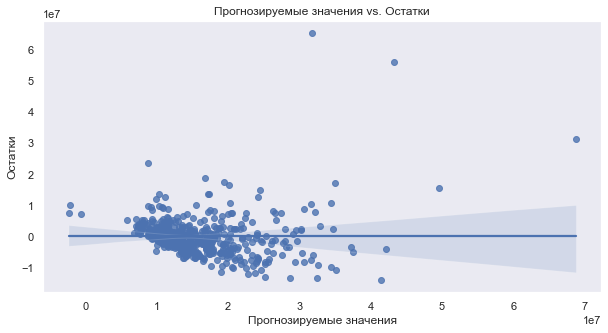

In [42]:
sns.set_style('dark')
print_resids(result.fittedvalues, result.resid);

C:\Users\Natil\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


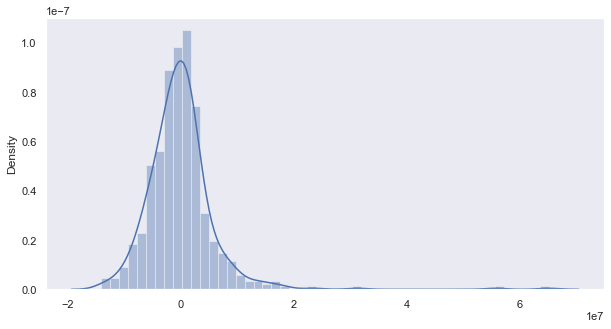

In [43]:
sns.distplot(result.resid);

## 8. Выбираем инструмент и проверяем его релевантность

__1 шаг.__ Оцениваем уравнение регрессии, в котором экзогенные переменные и инструмент предсказывают эндогенную переменную.

In [44]:
f = df['floor']
ft = df['floors_count']
rt = df['rooms_count']
tm = df['total_meters']
km = df['kitchen_meters']
CAO = df['is_CAO']
year = df['year_of_construction']
endog = df['house_category']
relevancy_result = smf.ols(formula = 'endog ~ f + ft + rt + tm + km + CAO + year', data = df).fit()
print(relevancy_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  endog   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     17.02
Date:                Sun, 12 May 2024   Prob (F-statistic):           2.13e-20
Time:                        17:34:24   Log-Likelihood:                -326.33
No. Observations:                 554   AIC:                             668.7
Df Residuals:                     546   BIC:                             703.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.0462      2.100     -4.307      0.0

__2 шаг.__ Вычислим расчетное значение тестовой F-статистики для проверки следующей гипотезы:

$ H_{0}: \hat{\beta}_{year\ of construction} = 0 $


Если эта гипотеза отвергается, то это значит, что инструмент (год постройки дома) вносит существенный вклад в объяснение изменений эндогенной переменной. Это говорит о релевантности инструмента. Обычно если расчетное значение тестовой F-статистики для проверки нулевой гипотезы больше 10, то инструменты признаются релевантными.

In [45]:
hypothesis = '(year = 0)'
print (relevancy_result.f_test(hypothesis))

<F test: F=array([[19.1839537]]), p=1.4234693005884154e-05, df_denom=546, df_num=1>


F-статистика для теста на незначимость инструмента равна 19.18, что больше 10. Можно заключить, что инструмент является релевантным.

## 9. Борьба с эндогенностью при помощи метода инстурментальных переменных.

In [46]:
exog = df[['floor', 'floors_count', 'rooms_count', 'total_meters', 'kitchen_meters', 'is_CAO', 'house_category' ]]
instr = df[['floor', 'floors_count', 'rooms_count', 'total_meters', 'kitchen_meters', 'is_CAO', 'year_of_construction' ]]

exog_constant = sm.add_constant(exog)
instr_constant = sm.add_constant(instr)
no_endog_result = IV2SLS(y, exog_constant, instrument = instr_constant).fit()

no_endog_result.summary()

C:\Users\Natil\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:                  price   R-squared:                       0.545
Model:                         IV2SLS   Adj. R-squared:                  0.539
Method:                     Two Stage   F-statistic:                     90.67
                        Least Squares   Prob (F-statistic):           2.93e-87
Date:                Sun, 12 May 2024                                         
Time:                        17:34:25                                         
No. Observations:                 554                                         
Df Residuals:                     546                                         
Df Model:                           7                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -7.701e+06   1.23e+06     -6.263      0.000   -1.01e+07   -5.29e+06
floor           7.119e+04   5.81e+04      1.224      0.221    -4.3e+04    1.85e+05
floors_count    1.565e+05   5.62e+04      2.786      0.006    4.62e+04    2.67e+05
rooms_count    -1.663e+06   1.49e+06     -1.113      0.266    -4.6e+06    1.27e+06
total_meters    4.957e+05    7.9e+04      6.278      0.000    3.41e+05    6.51e+05
kitchen_meters  7.562e+04   1.29e+05      0.584      0.559   -1.79e+05     3.3e+05
is_CAO          1.449e+07   1.94e+06      7.450      0.000    1.07e+07    1.83e+07
house_category -1.797e+06   3.28e+06     -0.548      0.584   -8.24e+06    4.64e+06
==============================================================================
Omnibus:                      510.792   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26886.549
Skew:                           3.822   Prob(JB):                         0.00
Kurtosis:                      36.261   Cond. No.                         297.
==============================================================================
"""

C:\Users\Natil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


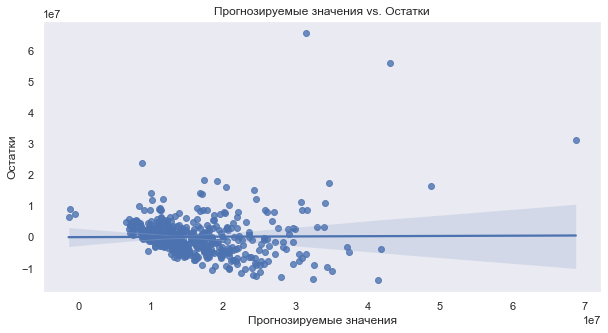

In [47]:
print_resids(no_endog_result.predict(), no_endog_result.resid);

C:\Users\Natil\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


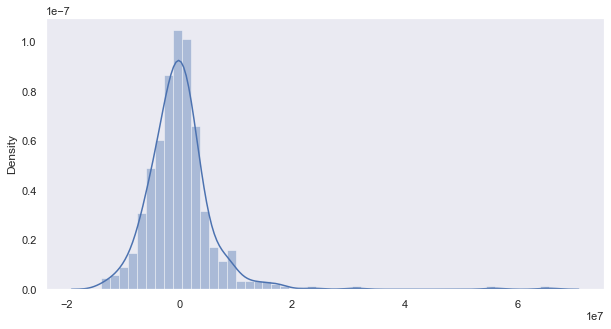

In [48]:
sns.distplot(no_endog_result.resid);

Корреляция переменных с остатками финальной модели:

In [49]:
residuals = no_endog_result.resid

correlations = np.corrcoef(np.concatenate((exog.T, [residuals])))

correlation_matrix = pd.DataFrame(correlations[:-1, -1], columns = ['Correlation with Residuals'], index = exog.columns.tolist())
correlation_matrix.round(2)


,Correlation with Residuals
floor,0.00
floors_count,0.00
rooms_count,-0.00
total_meters,-0.00
kitchen_meters,0.00
is_CAO,0.00
house_category,-0.07


## 10. Тест Хаусмана

Нулевая гипотеза заключается в том, что факторы модели экзогенны (матрица возможных эндогенных переменных и ошибки не скоррелированы), альтернатива — что эндогенны (матрица возможных эндогенных переменных и ошибки скоррелированы). 

__Шаги:__
1. Получаем прогнозируемые остатки регрессии с инстурментальной переменной ($\hat r$)
2. Оцениваем регрессию $Y = X\beta_{1} + \hat r \beta_{2} + \varepsilon$
3. Проверяем, значительно ли коэффициент при $\hat r$ отличается от 0, используя F-тест с 1 степенью свободы.

In [50]:
exog_constant['relevancy_resids'] = relevancy_result.resid

endog_test_results = sm.OLS(y, exog_constant).fit()

endog_test_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     82.28
Date:                Sun, 12 May 2024   Prob (F-statistic):           1.07e-88
Time:                        17:34:25   Log-Likelihood:                -9454.8
No. Observations:                 554   AIC:                         1.893e+04
Df Residuals:                     545   BIC:                         1.897e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -7.701e+06   1.23e+06     -6.274      0.000   -1.01e+07   -5.29e+06
floor             7.119e+04    5.8e+04      1.226      0.221   -4.28e+04    1.85e+05
floors_count      1.565e+05   5.61e+04      2.791      0.005    4.63e+04    2.67e+05
rooms_count      -1.663e+06   1.49e+06     -1.115      0.265   -4.59e+06    1.27e+06
total_meters      4.957e+05   7.88e+04      6.289      0.000    3.41e+05     6.5e+05
kitchen_meters    7.562e+04   1.29e+05      0.585      0.559   -1.78e+05     3.3e+05
is_CAO            1.449e+07   1.94e+06      7.463      0.000    1.07e+07    1.83e+07
house_category   -1.797e+06   3.27e+06     -0.549      0.583   -8.23e+06    4.63e+06
relevancy_resids -1.039e+06   3.33e+06     -0.312      0.755   -7.58e+06     5.5e+06
==============================================================================
Omnibus:                      504.475   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25858.320
Skew:                           3.754   Prob(JB):                         0.00
Kurtosis:                      35.617   Cond. No.                         957.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
null_hypothesis = '(relevancy_resids = 0)'
print (endog_test_results.f_test(null_hypothesis))

<F test: F=array([[0.09735985]]), p=0.7551405514316256, df_denom=545, df_num=1>


$F_{расчётное} = 0.097,\ p-value = 0.755.\ p-value > 0.05 $ => нулевая гипотеза не отвергается при любом разумном уровне значимости. Следовательно, матрица возможных эндогенных переменных и ошибки не скоррелированы => $\hat{\beta_{OLS}}$ эффективная и состоятельная, $\hat{\beta_{2SLS}}$ состоятельная => разница между оценками мала. На основе теста Хаусмана нет доказательства того, что переменная "категория дома" эндогенная. 